## Predicting King County House Prices
### Blog Post: https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c

# Business Case:
1. What factors influence price the most?
2. What factors are feasible for renovation
3. How accurately can we predict the value these features will have on price?



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

# Importing Data

#### Source: King County Housing Data
#### Timespan of the data (URL): This dataset is from 9/9/2014 - 1/10/2015

In [4]:
df = pd.read_csv('EXTR_ResBldg.csv')

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.head()

,Major,Minor,BldgNbr,NbrLivingUnits,Address,BuildingNumber,Fraction,DirectionPrefix,StreetName,StreetType,DirectionSuffix,ZipCode,Stories,BldgGrade,BldgGradeVar,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,9100,125,1,1,334 N 78TH ST 98103,334,,N,78TH,ST,,98103,1.0,7,0,860,0,0,0,0,0,1160,790,300,5,220,0,N,0,0,160,5,1,0,N,2,0,0,1,1,0,0,0,1922,0,0,0,0,3,0
1,9100,160,1,1,356 N 78TH ST 98103,356,,N,78TH,ST,,98103,1.0,7,0,1120,0,0,0,0,0,1120,840,0,0,0,0,N,60,0,0,5,1,0,N,2,0,0,1,1,0,0,0,1926,0,0,0,0,3,0
2,9100,180,1,1,7815 DAYTON AVE N 98103,7815,,,DAYTON,AVE,N,98103,1.0,7,0,1020,0,0,0,0,0,1320,1020,300,6,0,210,N,60,0,0,5,2,0,N,3,0,1,1,1,0,0,0,1926,0,0,0,0,3,0
3,9700,125,1,1,1507 34TH AVE 98122,1507,,,34TH,AVE,,98122,3.0,9,0,950,0,900,580,0,0,2430,180,0,0,180,200,,110,0,250,5,2,0,Y,4,1,0,3,0,1,0,1,2002,0,0,0,0,3,0
4,9760,10,1,1,16405 SE 66TH ST,16405,,SE,66TH,ST,,NaN,2.0,9,0,1450,0,1290,0,0,0,3520,780,780,8,0,450,Y,50,0,200,5,2,0,,5,1,1,2,1,0,0,0,2007,0,0,0,0,3,9000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513137 entries, 0 to 513136
Data columns (total 50 columns):
Major                 513137 non-null int64
Minor                 513137 non-null int64
BldgNbr               513137 non-null int64
NbrLivingUnits        513137 non-null int64
Address               513137 non-null object
BuildingNumber        513137 non-null object
Fraction              513137 non-null object
DirectionPrefix       512568 non-null object
StreetName            513137 non-null object
StreetType            513137 non-null object
DirectionSuffix       512568 non-null object
ZipCode               468499 non-null object
Stories               513137 non-null float64
BldgGrade             513137 non-null int64
BldgGradeVar          513137 non-null int64
SqFt1stFloor          513137 non-null int64
SqFtHalfFloor         513137 non-null int64
SqFt2ndFloor          513137 non-null int64
SqFtUpperFloor        513137 non-null int64
SqFtUnfinFull         513137 non-null int64

# Data Preparation

After looking through the original data and assesing what data was going to be valuable to answer our question, we decided to drop the columns titled (id, yr_renovated, lat, and long). This gave us a smaller data set in which we then proceeded to clean by dropping NaN and ? values from the waterfront and view columns. 

In [7]:
'''King County DataFrame that Includes logs of various variables '''
kc_data_full = pd.read_csv('kc_house_data.csv')
kc_data_full['sqft_basement'] = kc_data_full['sqft_basement'].replace("?",0)
kc_data_full['sqft_basement'] = kc_data_full['sqft_basement'].astype(float)
kc_data_full['zipcode'] = kc_data_full['zipcode'].astype(str)

kc_data_full = kc_data_full[~np.isnan(kc_data_full['waterfront'])]
kc_data_full = kc_data_full[~np.isnan(kc_data_full['view'])]

kc_data_full = kc_data_full.drop(['id','yr_renovated','lat','long'], axis=1)


#### Note: After dropping NaN records from waterfront and view, `kc_data_full` used to have 21,597 records, but now it has 19,164.

# Exploratory Data Analysis:
- Visualization
- OLS Model
- Multi-collinearity

## Visualization

Pairplot of Sqft Living, Bedrooms, Bathrooms in relation to Price.

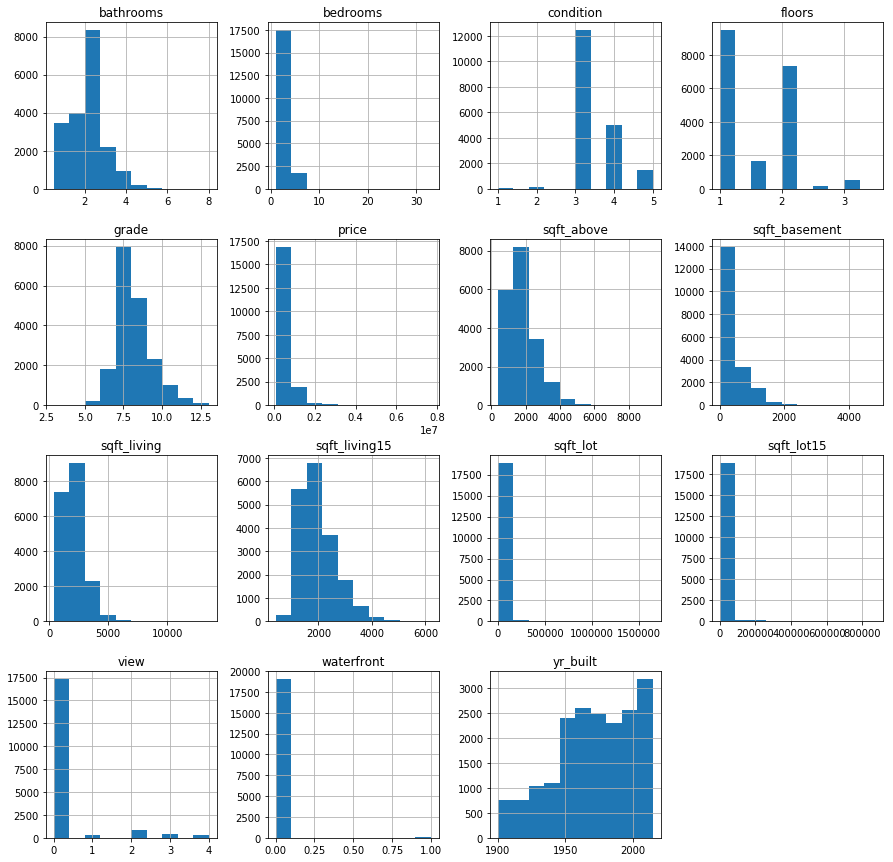

In [8]:
_=kc_data_full.hist(figsize=(15,15))

### Observations from the histograms above:
   Our target variable, price, is not a currently in a normal distribution. Most of the data appears to be skewed to the left side of the chart. We will have to normalize that data in order for our linear regression model to work properly. There are several other variables(sqft_living, bedrooms, yr_built) that we may normalize in order to see what change it has on our model.
   
   We also only used houses that were built after 1975, seeing as those houses would likley need rennovation, but are still likley to have a higher grade than house built before this time, and grade has a strong impact on the price. 

In [9]:
kc_train = kc_data_full[:9000]
kc_train = kc_train.loc[kc_train['yr_built'] > 1975]

log_sqft_living = np.log(kc_train['sqft_living'])
log_bedrooms = np.log(kc_train['bedrooms'])
log_yr_built = np.log(kc_train['yr_built'])

kc_train['log_sqft'] = log_sqft_living
kc_train['log_bedrooms'] = log_bedrooms
kc_train['log_yr_built'] = log_yr_built

kc_train['price'] = np.log(kc_train['price'])

In [10]:
kc_train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,log_sqft,log_bedrooms,log_yr_built
4,2/18/2015,13.142166,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,1800,7503,7.426549,1.098612,7.594381
5,5/12/2014,14.022525,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,1530.0,2001,98053,4760,101930,8.597851,1.386294,7.601402
6,6/27/2014,12.458775,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,0.0,1995,98003,2238,6819,7.447168,1.098612,7.598399
9,3/12/2015,12.685408,3,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,0.0,2003,98038,2390,7570,7.544332,1.098612,7.602401
13,10/7/2014,12.899220,3,1.75,1370,9680,1.0,0.0,0.0,4,7,1370,0.0,1977,98074,1370,10208,7.222566,1.098612,7.589336


/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


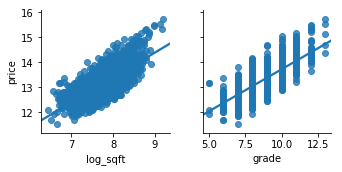

In [11]:
_=sns.pairplot(kc_train,x_vars=['log_sqft','grade'], y_vars='price', kind='reg')
plt.savefig('pairplot_graph.png')

We used this pairplot in order to vizualize and understand if there were linear relationships between these variables and price.

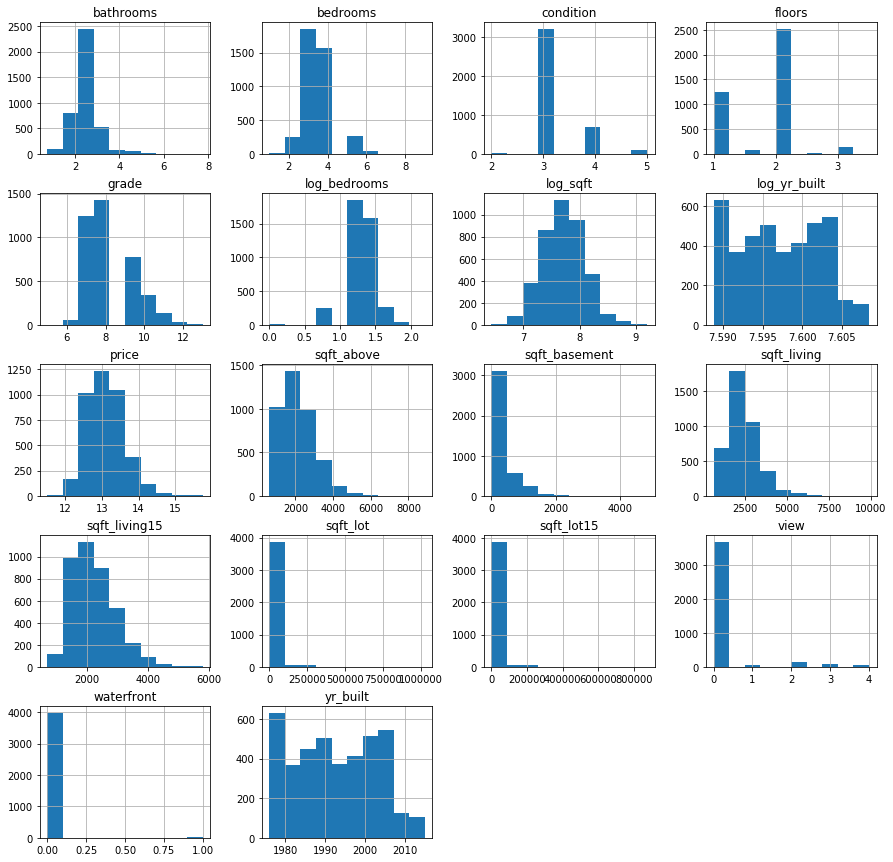

In [12]:
_=kc_train.hist(figsize=(15,15))

##### This visual displays that after we normalized the features `'log_sqft', 'price', 'log_bedrooms, 'log_yr_built'` that they are all shaped in a much more normal distribution

## Multi-Collinearity of Features 

#### Visualizing multi-collinearity will help us avoid over-fitting our model on our training data. 

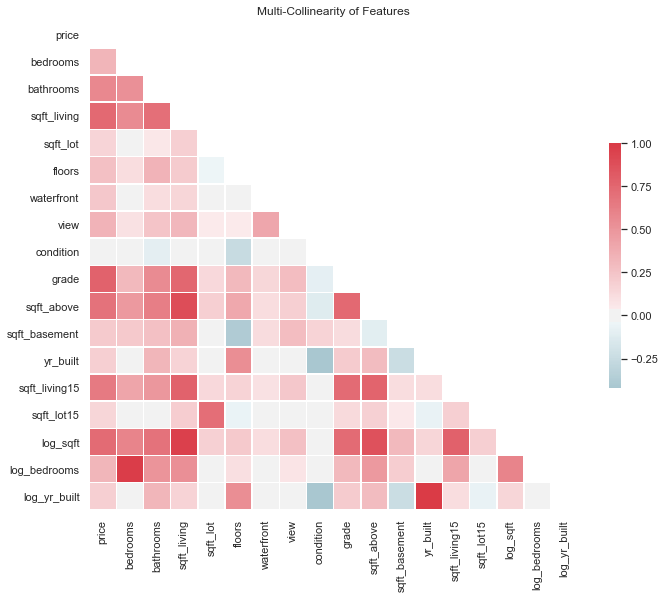

In [13]:
sns.set(style="white")

# Create a covariance matrix
corr = kc_train.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,center=0,square=True, 
            linewidth=.5, cbar_kws={'shrink': .5})

ax.set_title('Multi-Collinearity of Features')
plt.savefig('correlation.png')

##### This is another representation of the colinearity of variables. Collineariyt is measured on a scaled from (-1 to 1). Values closer to these edges represent higher collinearity. 

In [14]:
(kc_train.iloc[:, 1:]).corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,log_sqft,log_bedrooms,log_yr_built
price,1.000000,0.333824,0.573733,0.750144,0.159711,0.263915,0.228608,0.342739,-0.033542,0.776819,0.692023,0.217946,0.188935,0.649516,0.151156,0.730969,0.324619,0.188902
bedrooms,0.333824,1.000000,0.525243,0.555573,-0.001710,0.109082,-0.007361,0.090041,0.023444,0.310787,0.483128,0.219746,0.039705,0.415628,-0.008923,0.597750,0.976754,0.039659
bathrooms,0.573733,0.525243,1.000000,0.707180,0.060535,0.342931,0.116618,0.247188,-0.101347,0.559682,0.623351,0.264076,0.319541,0.493643,0.033165,0.685688,0.507111,0.319677
sqft_living,0.750144,0.555573,0.707180,1.000000,0.194875,0.205426,0.155907,0.316483,-0.029695,0.753803,0.889693,0.356907,0.164610,0.773300,0.197398,0.962018,0.539466,0.164710
sqft_lot,0.159711,-0.001710,0.060535,0.194875,1.000000,-0.047022,-0.003252,0.041593,0.022280,0.137697,0.190751,0.033682,-0.032241,0.139313,0.714033,0.184144,-0.003813,-0.032068
floors,0.263915,0.109082,0.342931,0.205426,-0.047022,1.000000,0.028097,0.045996,-0.253236,0.302438,0.405470,-0.374519,0.544567,0.165609,-0.054951,0.221746,0.105932,0.544850
waterfront,0.228608,-0.007361,0.116618,0.155907,-0.003252,0.028097,1.000000,0.408114,-0.010434,0.143704,0.108372,0.119347,-0.006491,0.092023,0.009222,0.116600,-0.013462,-0.006466
view,0.342739,0.090041,0.247188,0.316483,0.041593,0.045996,0.408114,1.000000,0.028578,0.283684,0.192631,0.286798,-0.020116,0.228497,0.033674,0.271105,0.078472,-0.020094
condition,-0.033542,0.023444,-0.101347,-0.029695,0.022280,-0.253236,-0.010434,0.028578,1.000000,-0.090826,-0.116267,0.170047,-0.418058,-0.028857,0.036486,-0.033000,0.026226,-0.418352
grade,0.776819,0.310787,0.559682,0.753803,0.137697,0.302438,0.143704,0.283684,-0.090826,1.000000,0.742900,0.121558,0.210972,0.726653,0.129403,0.732353,0.311303,0.211174


#####  The chart here is stating that any feature that has a collinearity of .75 or higher should be dropped from the dataframe to possibly achieve a better predictability model. Hence, any coefficient that has the highest number of "True" should be analyzed.

In [15]:
abs(kc_train.corr()) > .75

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,log_sqft,log_bedrooms,log_yr_built
price,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,True,False,False,True,False,False,False,False,False,True,True,False,False,True,False,True,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False


# Linear Regression Modeling

In [16]:
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Creating a function that will easily create and compares models. This will aid the parameter tuning portion of the experiment

In [78]:
# class RunLinearModels
#     def __init__(self, df):
#         '''Intializing RunLinearModels'''
#         self.df = df
#         self.X 
    
#     def train_test(self, self.df):
#         X = df[feature_cols]
#         y = df['price']
#         X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
    
        
        

def create_models(df, feature_cols):
    '''This is a function that outputs the Intercept, Coefficients, 3 types of Errors, and R-Squared'''
    X = df[feature_cols]
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f'Intercept of the regression line:',lr.intercept_)
    print(f'Coefficients:',lr.coef_)
    print('\n')
    
    y_pred = lr.predict(X_test)

    
#     print(f'Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print(f'Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print(f'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#     print(f'R-Squared:',round(lr.score(X,y),3))
#     print('\n')
    
    print(f'Mean Absolute Error exp:', np.exp(metrics.mean_absolute_error(y_test, y_pred)))
    print(f'Mean Squared Error exp:', np.exp(metrics.mean_squared_error(y_test, y_pred)))
    print(f'Root Mean Squared Error:', np.exp(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    predictions =  np.array(np.exp(lr.predict(X_test)))
    standardized_y= np.exp((y_test))
    print(np.sqrt(sum((standardized_y - predictions) ** 2) / len(standardized_y)))
    scores = cross_val_score(lr, X, y, cv=7)
    print('Cross Validated RMSE Scores', np.mean(scores))
    print('MAE')
    print(np.log(metrics.mean_absolute_error(standardized_y, predictions)))
    print('LR Coef')
    print(np.exp(lr.coef_))




# Baseline Modeling
### Sqft vs Price

These are exploartory models, so that we can compare our cross validated data with baseline models. 

In [79]:
create_models(df=kc_train, feature_cols=['sqft_living'])

Intercept of the regression line: 12.137724235120006
Coefficients: [0.00040736]


Mean Absolute Error exp: 1.3125199043376443
Mean Squared Error exp: 1.1162736082765905
Root Mean Squared Error: 1.3932741107222306
300976.2168267116
Cross Validated RMSE Scores 0.5588877929811605
MAE
11.966243332446796
LR Coef
[1.00040745]


### Sqft Living, Bedrooms, Bathrooms vs Price.
All of these factors are attributes of the house, and may increase or decrease price depending on whether they increase or decrease.

In [80]:
create_models(df=kc_train, feature_cols=['sqft_living','bedrooms','bathrooms'])

Intercept of the regression line: 12.222960350279635
Coefficients: [ 0.00039325 -0.08971112  0.10312941]


Mean Absolute Error exp: 1.2961961175628443
Mean Squared Error exp: 1.1084008332354496
Root Mean Squared Error: 1.3782420349527058
265527.24831617414
Cross Validated RMSE Scores 0.5758234886880071
MAE
11.9595326475976
LR Coef
[1.00039333 0.91419524 1.10863487]


### SqFt_Living15, Sqft_Lot15, Grade vs Price: 
These factors were selected to see if there was a correlation between quality of neighborhood vs the price of home.

In [81]:
create_models(df=kc_train, feature_cols=['sqft_living15','sqft_lot15','grade'])

Intercept of the regression line: 10.528488074479956
Coefficients: [1.14607026e-04 7.43456202e-07 2.82753964e-01]


Mean Absolute Error exp: 1.2742517565554827
Mean Squared Error exp: 1.0996370123900456
Root Mean Squared Error: 1.3609574723006328
289052.6646383658
Cross Validated RMSE Scores 0.6170971815444233
MAE
11.909987534812164
LR Coef
[1.00011461 1.00000074 1.32677869]


## Model Comparison Graph

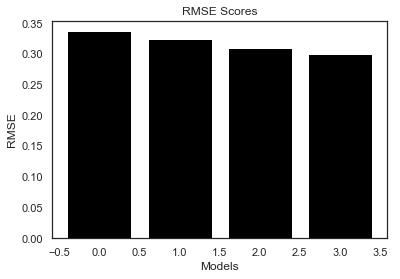

In [82]:
Values ={'Model 1': 0.337, 'Model 2': 0.325, 
         'Model 3': 0.310, 'Model 4': 0.300,}

plt.bar(range(len(Values)), list(Values.values()), color = ('Black'))
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Model 4


In [83]:
create_models(df=kc_train, feature_cols=['log_sqft', 'grade'])

Intercept of the regression line: 7.566736601999239
Coefficients: [0.47844879 0.22669637]


Mean Absolute Error exp: 1.2597019998013952
Mean Squared Error exp: 1.088523342754516
Root Mean Squared Error: 1.3380886924499398
204886.6806283186
Cross Validated RMSE Scores 0.6570903466034473
MAE
11.763864371408713
LR Coef
[1.61356947 1.25444892]


In [84]:
feature_col = ['log_sqft', 'grade']
X = kc_train[feature_col]
y = kc_train['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.5)

linreg_final = LinearRegression()
results = linreg_final.fit(X_train, y_train)

print(np.exp(linreg_final.intercept_))

1682.8619907018315


In [85]:
print (X_train.shape, y_train.shape)


(2009, 2) (2009,)


In [86]:
predictions = create_models(df=kc_train, feature_cols=['log_sqft', 'grade'])

Intercept of the regression line: 7.614214598591337
Coefficients: [0.47114025 0.22771601]


Mean Absolute Error exp: 1.262024906991307
Mean Squared Error exp: 1.0920042704195252
Root Mean Squared Error: 1.3453751061886114
269583.04014170275
Cross Validated RMSE Scores 0.6570903466034473
MAE
11.864233355207984
LR Coef
[1.60181963 1.25572866]


# Model 5 (Final Model)

Model 4 was fairly accurate when considering R-Squared, however the RMSE was way too high. So we decided to take the 90th percentile of our data in order to remove outliers, in hopes that this would allow our model to more accurately predict housing prices. 

We use the built in Numpy percentile function to create a slice of our original data frame with only the top 90% of prices to avoid outliers.

In [87]:
kc_90_df = np.percentile(kc_train['price'], 90)
kc_90 = kc_train.drop(kc_train[kc_train['price'] > kc_90_df].index)


In [89]:
create_models(kc_90, feature_cols=['log_sqft', 'grade', 'condition'])

Intercept of the regression line: 8.320940251347288
Coefficients: [0.40150988 0.19510196 0.01755806]


Mean Absolute Error exp: 1.2505925376421636
Mean Squared Error exp: 1.0764441400513036
Root Mean Squared Error: 1.3118122186505012
123129.20949867561
Cross Validated RMSE Scores 0.5177621710851023
MAE
11.504849662186562
LR Coef
[1.49407887 1.21543491 1.01771311]


These are our coeffiecients of our model, these will help us describe the exact impact our features have on the houses price. 

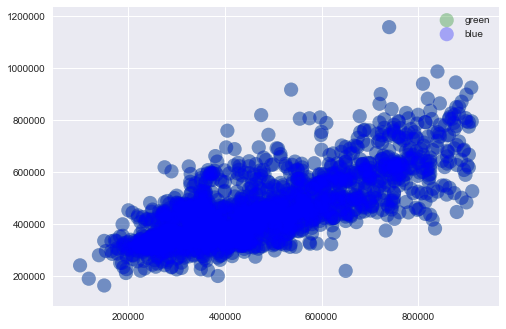

In [165]:
fig, ax = plt.subplots()
for color in ['green', 'blue']:
    x = standardY1
    y = standard1
    scale = 200.0
    ax.scatter(x, y, c=color, s=scale, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

Our last visual represents the true Y values vs our predicted values, which appears to have a pretty similar layout. 